# Modelo de deteccion de phishing en mensajes de texto  

Referencias:  
Abdullah, N., (2024). Phishing Email Dataset. https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset/data?select=phishing_email.csv



#### Analisis Exploratorio

In [10]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import re
import unicodedata
import contractions
import textsearch
import matplotlib
import pylab as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
# Get sklearn version
import sklearn
print(sklearn.__version__)

1.5.2


In [12]:
df = pd.read_csv("datasets/Messages/phishing_email.csv")
df.head(10)

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
5,hpl nom may 31 2001 see attached file hplno 53...,0
6,9760 tried get fancy address came back forward...,0
7,hpl noms february 15 2000 see attached file hp...,0
8,fw pooling contract template original message ...,0
9,hpl nom march 28 2000 see attached file hplo 3...,0


In [13]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
(82486, 2)


In [14]:
print("Good emails")
df[df.label == 0].sample(5)

Good emails


,text_combined,label
11547,abb enron canada may close selling abb units 3...,0
46301,administrator hjvpsdifferentperspectivescom ni...,0
15860,start date 12 27 01 hourahead hour 20 start da...,0
13318,gtv ii update louise update dave nommensen sig...,0
21838,backtesting graphs semivariance var fyi forwar...,0


In [15]:
print("Bad emails")
df[df.label == 1].sample(5)

Bad emails


,text_combined,label
67700,cnn alerts checkoipalsecuritypacificcom cnn al...,1
24330,ready get hello viagra 1 med struggle mens ere...,1
10624,_ know get search engine results submitting we...,1
23235,v yyou save yo abetment ur medlcations 70 phar...,1
46444,daily top 10 thainenoitaageomicrones daily top...,1


In [16]:
df.isnull().sum()

text_combined    0
label            0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

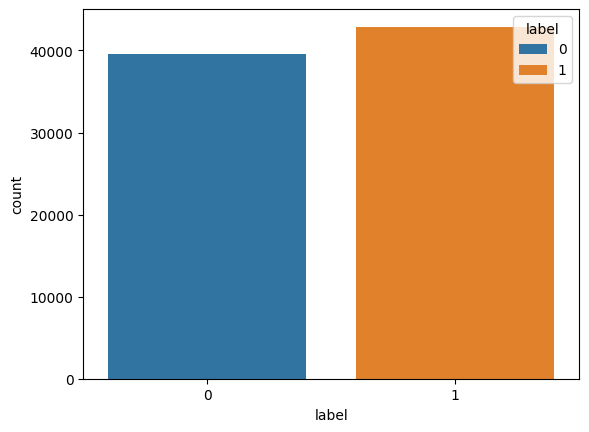

In [17]:
sns.countplot(x='label', data=df, hue='label')

#### Tokenizacion

In [18]:
# Hacer minusculas los mensajes
df['text_combined'] = df['text_combined'].str.lower()

In [19]:
# Remove accents
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

df['text_combined'] = df['text_combined'].apply(remove_accents)

df

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [20]:
# Remove special characters
def remove_special_characters(text):
    text = re.sub(r'[^a-zA-z\s]', '', text)
    return text

df['text_combined'] = df['text_combined'].apply(remove_special_characters)
df

,text_combined,label
0,hpl nom may see attached file hplno xls hpl...,0
1,nom actual vols th forwarded sabrae zajac hou...,0
2,enron actuals march april estimated actuals...,0
3,hpl nom may see attached file hplno xls hpl...,0
4,hpl nom june see attached file hplno xls hp...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [21]:
# Correct contractions
def correct_contractions(text):
    return contractions.fix(text)

df['text_combined'] = df['text_combined'].apply(correct_contractions)
df

,text_combined,label
0,hpl nom may see attached file hplno xls hpl...,0
1,nom actual vols th forwarded sabrae zajac hou...,0
2,enron actuals march april estimated actuals...,0
3,hpl nom may see attached file hplno xls hpl...,0
4,hpl nom june see attached file hplno xls hp...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [22]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Andre\AppData\Roaming\nltk_data...
[

True

In [23]:
nltk.download('punkt')
df['text_combined'] = df.apply(lambda row: nltk.word_tokenize(row['text_combined']), axis=1)
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text_combined,label
0,"[hpl, nom, may, see, attached, file, hplno, xl...",0
1,"[nom, actual, vols, th, forwarded, sabrae, zaj...",0
2,"[enron, actuals, march, april, estimated, actu...",0
3,"[hpl, nom, may, see, attached, file, hplno, xl...",0
4,"[hpl, nom, june, see, attached, file, hplno, x...",0
...,...,...
82481,"[info, advantageapartmentscom, infoadvantageap...",1
82482,"[monkeyorg, helpdeskmonkeyorg, monkeyorg, hi, ...",1
82483,"[help, center, infohelpcentercoza_infohelpcent...",1
82484,"[metamask, infosofamekarcom, verify, metamask,...",1


In [24]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    return [word for word in text if word not in stopwords]

df['text_combined'] = df['text_combined'].apply(remove_stopwords)
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text_combined,label
0,"[hpl, nom, may, see, attached, file, hplno, xl...",0
1,"[nom, actual, vols, th, forwarded, sabrae, zaj...",0
2,"[enron, actuals, march, april, estimated, actu...",0
3,"[hpl, nom, may, see, attached, file, hplno, xl...",0
4,"[hpl, nom, june, see, attached, file, hplno, x...",0
...,...,...
82481,"[info, advantageapartmentscom, infoadvantageap...",1
82482,"[monkeyorg, helpdeskmonkeyorg, monkeyorg, hi, ...",1
82483,"[help, center, infohelpcentercoza_infohelpcent...",1
82484,"[metamask, infosofamekarcom, verify, metamask,...",1


In [25]:
ps = PorterStemmer()

def stemming(text):
    return [ps.stem(word) for word in text]

df['text_combined'] = df['text_combined'].apply(stemming)


In [26]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def lemmatization(text):
    return [wnl.lemmatize(word) for word in text]

df['text_combined'] = df['text_combined'].apply(lemmatization)
df

,text_combined,label
0,"[hpl, nom, may, see, attach, file, hplno, xl, ...",0
1,"[nom, actual, vol, th, forward, sabra, zajac, ...",0
2,"[enron, actual, march, april, estim, actual, m...",0
3,"[hpl, nom, may, see, attach, file, hplno, xl, ...",0
4,"[hpl, nom, june, see, attach, file, hplno, xl,...",0
...,...,...
82481,"[info, advantageapartmentscom, infoadvantageap...",1
82482,"[monkeyorg, helpdeskmonkeyorg, monkeyorg, hi, ...",1
82483,"[help, center, infohelpcentercoza_infohelpcent...",1
82484,"[metamask, infosofamekarcom, verifi, metamask,...",1


In [27]:
# Remove words with length less than 4 characters
def remove_short_words(text):
    return [word for word in text if len(word) > 3]

df['text_combined'] = df['text_combined'].apply(remove_short_words)

In [28]:
# Normalize text
def normalize_text(text):
    return ' '.join(text)

df['text_combined'] = df['text_combined'].apply(normalize_text)
df

,text_combined,label
0,attach file hplno hplno,0
1,actual forward sabra zajac enron capit trade r...,0
2,enron actual march april estim actual march fl...,0
3,attach file hplno hplno,0
4,june attach file hplno hplno,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg josepass...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verifi metamask wall...,1


In [29]:
import string 

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    return text

df['text_combined'] = df['text_combined'].apply(text_preprocessing)
df

,text_combined,label
0,attach file hplno hplno,0
1,actual forward sabra zajac enron capit trade r...,0
2,enron actual march april estim actual march fl...,0
3,attach file hplno hplno,0
4,june attach file hplno hplno,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg josepass...,1
82483,help center infohelpcentercozainfohelpcenterco...,1
82484,metamask infosofamekarcom verifi metamask wall...,1


In [30]:
# Remove specific words
def remove_specific_words(text):
    specific_words = ['subject', 'submiss', 'note', 'viru', 'virutotal', 
                      'submissionid', 'email', 'messag', 'file', 'enron', 
                      'mail', 'sender', 'receiv', 'attach', 'receiv', 'total']

    return ' '.join([word for word in text.split() if word not in specific_words])

df['text_combined'] = df['text_combined'].apply(remove_specific_words)

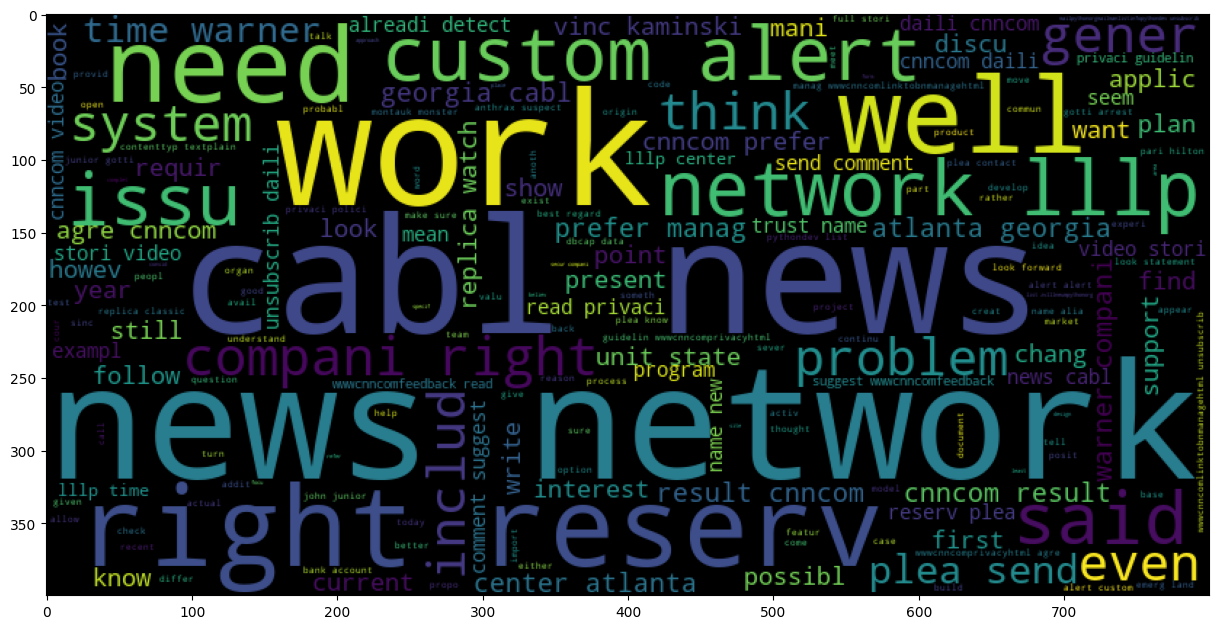

In [31]:
cloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(' '.join(df['text_combined']))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)

In [32]:
data = df.sample(frac=1).reset_index(drop=True)
data

,text_combined,label
0,dear friend courtesi busi opportun take libert...,1
1,jeroen ruigrok werven kyfxfucinnomineorg chris...,0
2,pamelablinkesecom result feedback form submit ...,1
3,alex disparagingjmjmacconsultingcom addtocarth...,1
4,usergvcceaschallengecc eoin parker write afrai...,0
...,...,...
82481,darien librari eakkghhbnpedarienlibraryorg for...,0
82482,resid option forward zimin zimin stinson gibne...,0
82483,updat confirmlog want give quick updat confirm...,0
82484,dear websit oper thought could help success fe...,1


In [33]:
# Nan values
data.isnull().sum()

data = data.dropna()

In [34]:
# Save data
data.to_csv('datasets/Messages/phishing_email_clean.csv', index=False)

#### Modelo TF-IDF

In [35]:
data = pd.read_csv('datasets/Messages/phishing_email_clean.csv')

tv = TfidfVectorizer(max_features=8000, ngram_range=(1, 3))
# Remove np.nan values
data['text_combined'] = data['text_combined'].replace(np.nan, '', regex=True)
tfidf_obj = tv.fit_transform(data['text_combined'])
tv_matrix = tfidf_obj.toarray()

vocab = tv.get_feature_names_out()
tfIDF_df = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
tfIDF_df

,aaai,aaron,aaron kulki,abacha,abandon,abidjan,abidjan cote,abil,abort,abraham,...,zero,zhang,zimbabw,zimin,zone,zonk,zurich,zvlllneumpythonorg,zvlllneumpythonorg mailpythonorgmailmanlistinfopythondev,zvlllneumpythonorg mailpythonorgmailmanlistinfopythondev unsubscrib
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
82482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.64,0.0,0.0,0.0,0.0,0.0,0.0
82483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
82484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Save tfidf model
import joblib
joblib.dump(tv, 'models/tfidf_model.pkl')

['models/tfidf_model.pkl']

<Axes: >

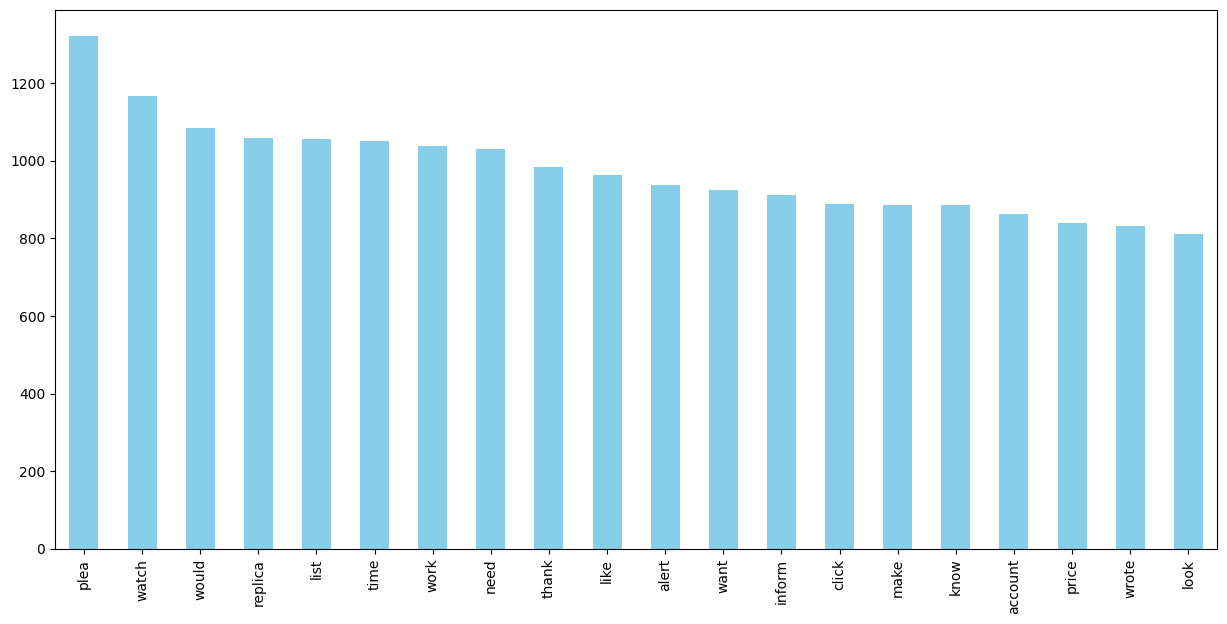

In [37]:
# Frequency of words
word_freq = tfIDF_df.sum()
word_freq = word_freq.sort_values(ascending=False)

word_freq[:20].plot(kind='bar', figsize=(15, 7), color='skyblue')

In [38]:
word_freq[:30]

plea       1322.47
watch      1166.21
would      1083.18
replica    1058.81
list       1056.30
time       1050.44
work       1037.23
need       1030.93
thank       984.32
like        963.01
alert       937.30
want        925.27
inform      912.86
click       887.44
make        886.92
know        885.05
account     863.97
price       839.87
wrote       830.70
look        811.53
help        804.17
best        782.87
compani     780.56
free        771.01
custom      756.65
money       755.83
name        739.38
chang       731.58
love        720.02
offer       714.88
dtype: float64

In [39]:
tfIDF_df.to_csv('datasets/Messages/phishing_emailS_tfidf.csv', index=False)

# Entrenamiento de modelos

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
data = pd.read_csv('datasets/Messages/phishing_email_clean.csv')
tfIDF_df = pd.read_csv('datasets/Messages/phishing_email_tfidf.csv')

In [42]:
X = tfIDF_df
y = data['label']
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, test_size=0.2, random_state=42)

In [43]:
X_valid.sample(5)

,aaai,aaron,aaron kulki,abacha,abandon,abidjan,abidjan cote,abil,abort,abraham,...,zero,zhang,zimbabw,zimin,zone,zonk,zurich,zvlllneumpythonorg,zvlllneumpythonorg mailpythonorgmailmanlistinfopythondev,zvlllneumpythonorg mailpythonorgmailmanlistinfopythondev unsubscrib
37541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Lazy Predict


In [35]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [6:07:35<00:00, 760.54s/it]    

                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
ExtraTreesClassifier        0.98               0.98     0.98      0.98   
CalibratedClassifierCV      0.97               0.97     0.97      0.97   
LogisticRegression          0.97               0.97     0.97      0.97   
LinearSVC                   0.96               0.96     0.96      0.96   
NuSVC                       0.96               0.96     0.96      0.96   
BaggingClassifier           0.96               0.96     0.96      0.96   
DecisionTreeClassifier      0.94               0.94     0.94      0.94   
ExtraTreeClassifier         0.91               0.91     0.91      0.91   
AdaBoostClassifier          0.90               0.90     0.90      0.90   
GaussianNB                  0.84               0.85     0.85      0.84   
KNeighborsClassifier        0.78               0.77     0.77      0.77   
BernoulliNB                 0.75      

In [36]:
# Show the top 5 models
models.head(5)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.98,0.98,0.98,0.98,429.01
CalibratedClassifierCV,0.97,0.97,0.97,0.97,666.13
LogisticRegression,0.97,0.97,0.97,0.97,115.51
LinearSVC,0.96,0.96,0.96,0.96,203.44
NuSVC,0.96,0.96,0.96,0.96,14959.14


#### Random Forest

In [44]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_valid)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6236
           1       0.98      0.97      0.97      6962

    accuracy                           0.97     13198
   macro avg       0.97      0.97      0.97     13198
weighted avg       0.97      0.97      0.97     13198



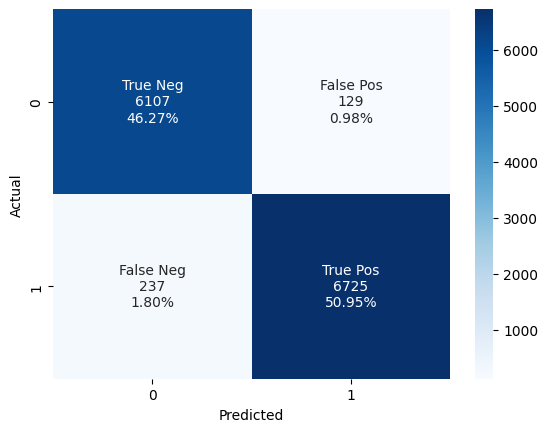

In [45]:
# Evaluate the model
cm = confusion_matrix(y_valid, y_pred_rf)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
print(classification_report(y_valid, y_pred_rf))

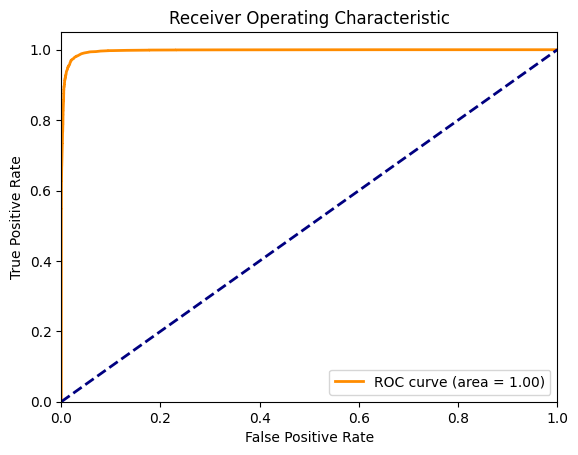

In [48]:
# Graph roc curve and auc score
from sklearn.metrics import roc_curve, auc

probabilities = rf_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


In [57]:
# K-fold cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X_train_plus_valid, y_train_plus_valid, cv=10, scoring='accuracy')

print("Scores")
print(scores)

print("Overall Accuracy:" , scores.mean())

Scores
[0.97287468 0.97802697 0.97332929 0.97378391 0.97514775 0.97590544
 0.97226853 0.97529929 0.97271901 0.97362837]
Overall Accuracy: 0.9742983231910592


#### ExtraTrees

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6236
           1       0.99      0.97      0.98      6962

    accuracy                           0.98     13198
   macro avg       0.98      0.98      0.98     13198
weighted avg       0.98      0.98      0.98     13198



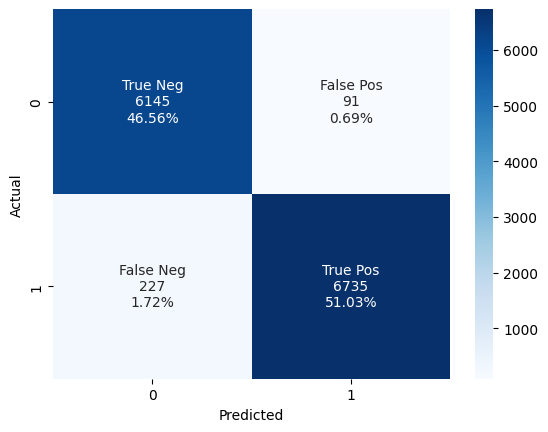

In [46]:
# Import extratrees classifier
from sklearn.ensemble import ExtraTreesClassifier

extra_trees = ExtraTreesClassifier(n_estimators=100)
extra_trees.fit(X_train, y_train)
y_pred_extra_trees = extra_trees.predict(X_valid)

# Evaluate the model
cm = confusion_matrix(y_valid, y_pred_extra_trees)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_valid, y_pred_extra_trees))


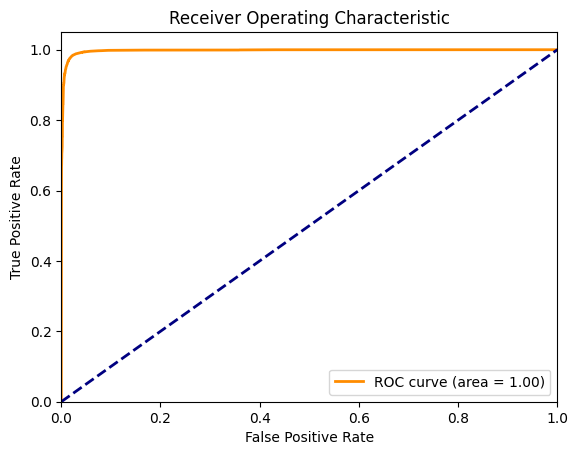

In [49]:
# Graph roc curve and auc score
probabilities = extra_trees.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

In [58]:
# K-fold cross validation
scores = cross_val_score(extra_trees, X_train_plus_valid, y_train_plus_valid, cv=10, scoring='accuracy')

print("Scores")
print(scores)

print("Overall Accuracy:" , scores.mean())


Scores
[0.97802697 0.98105774 0.97833005 0.97681467 0.9777239  0.9789362
 0.97696621 0.9757539  0.97711428 0.97620491]
Overall Accuracy: 0.9776928825456528


In [50]:
# Guardar el modelo
import joblib
joblib.dump(extra_trees, './models/msgs_Extra_Trees_model.pkl')


['./models/msgs_Extra_Trees_model.pkl']